In [ ]:
!pip install torchviz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.1 MB/s eta 0:00:00


In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/utilities_general.py"

In [ ]:
import pandas as pd
import numpy as np

from typing import List, Tuple, Union
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim


from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

from random import sample
from torchviz import make_dot

path_prefix = "/content/drive/MyDrive/Colab Notebooks/MachineLearning_DimensionalityReduction"
embeddings_file_path = f"{path_prefix}/df_embeddings.pkl"

N_FEATURES = 2048
TOP_K = 10

In [ ]:
df_embeddings = pd.read_pickle(embeddings_file_path).head(512)
array_start = np.array(df_embeddings["embeddings"].to_list())

In [ ]:
class DimReductionCosineSpaceDataset(Dataset):
  def __init__(self, vectors):
    super().__init__()
    self.vectors = vectors
    self.cosine_similarity_matrix = cosine_similarity(array_start)

  def __len__(self):
    return len(self.vectors)

  def __getitem__(self, idx):
    return self.vectors[idx]

dataset = DimReductionCosineSpaceDataset(vectors=array_start)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 2),
            nn.ReLU(True),
            nn.Linear(encoding_dim * 2, encoding_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim * 2),
            nn.ReLU(True),
            nn.Linear(encoding_dim * 2, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        # decoded = self.decoder(encoded)
        return encoded

In [ ]:
X = np.stack(df_embeddings['embeddings'].values)
X_tensor = torch.FloatTensor(X)

# Split data
X_train, X_test = train_test_split(X_tensor, test_size=0.2, random_state=42)

In [ ]:
            <ul>Cosine Similarity Loss Encoder | 0128</ul>
            <ul>Cosine Similarity Loss Encoder | 0256</ul># Define helper function to compute cosine similarity matrix
def cosine_similarity_matrix(x):
    x_norm = x / (x.norm(dim=1, keepdim=True) + 1e-8)
    return torch.mm(x_norm, x_norm.t())

# Prepare data (same as before)
X = np.stack(df_embeddings['embeddings'].values)
X_tensor = torch.FloatTensor(X)
X_train, X_test = train_test_split(X_tensor, test_size=0.2, random_state=42)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train), batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test), batch_size, shuffle=False)

for encoding_dim in [16, 32, 64, 128, 256, 512, 1024]:  # Fixed variable name typo
    print_formatter(f"Encoder|Dimensions|{encoding_dim:04}")
    input_dim = X_train.shape[1]
    model = Autoencoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    num_epochs = 1000
    patience = 10
    min_delta = 1e-5
    best_loss = float('inf')
    epochs_no_improve = 0
    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        num_batches = 0

        for batch in train_loader:
            inputs = batch[0]
            optimizer.zero_grad()
            outputs = model(inputs)

            # Compute cosine similarity matrices
            cosim_input = cosine_similarity_matrix(inputs)
            cosim_output = cosine_similarity_matrix(outputs)

            # Calculate loss and backpropagate
            loss = criterion(cosim_output, cosim_input)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            num_batches += 1

        avg_train_loss = train_loss / num_batches
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        test_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch in test_loader:
                inputs = batch[0]
                outputs = model(inputs)

                cosim_input = cosine_similarity_matrix(inputs)
                cosim_output = cosine_similarity_matrix(outputs)

                loss = criterion(cosim_output, cosim_input)
                test_loss += loss.item()
                num_batches += 1

        avg_test_loss = test_loss / num_batches
        history['test_loss'].append(avg_test_loss)

        print_formatter(f'Epoch {epoch+1:04}/{num_epochs:04} | '
              f'Train Loss: {avg_train_loss:.6f} | '
              f'Test Loss: {avg_test_loss:.6f}')

        # Early stopping check
        if avg_test_loss < best_loss - min_delta:
            best_loss = avg_test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}\n')
                break

    # Encode all embeddings
    model.eval()
    with torch.no_grad():
        embeddings_tensor = torch.FloatTensor(np.stack(df_embeddings['embeddings'].values))
        encoded = model.encoder(embeddings_tensor).numpy()

    df_embeddings[f'embeddings_ae_{encoding_dim:04}'] = list(encoded)

[2025-08-11 03:56:44] Encoder|Dimensions|0016
[2025-08-11 03:56:52] Epoch 0001/1000 | Train Loss: 0.041107 | Test Loss: 0.021986
[2025-08-11 03:56:52] Epoch 0002/1000 | Train Loss: 0.020483 | Test Loss: 0.017029
[2025-08-11 03:56:52] Epoch 0003/1000 | Train Loss: 0.017276 | Test Loss: 0.016216
[2025-08-11 03:56:52] Epoch 0004/1000 | Train Loss: 0.012587 | Test Loss: 0.013932
[2025-08-11 03:56:52] Epoch 0005/1000 | Train Loss: 0.011515 | Test Loss: 0.012644
[2025-08-11 03:56:52] Epoch 0006/1000 | Train Loss: 0.009719 | Test Loss: 0.011341
[2025-08-11 03:56:52] Epoch 0007/1000 | Train Loss: 0.008679 | Test Loss: 0.010514
[2025-08-11 03:56:52] Epoch 0008/1000 | Train Loss: 0.007428 | Test Loss: 0.010185
[2025-08-11 03:56:52] Epoch 0009/1000 | Train Loss: 0.006636 | Test Loss: 0.010160
[2025-08-11 03:56:52] Epoch 0010/1000 | Train Loss: 0.006506 | Test Loss: 0.009525
[2025-08-11 03:56:52] Epoch 0011/1000 | Train Loss: 0.006053 | Test Loss: 0.009319
[2025-08-11 03:56:52] Epoch 0012/1000 | T

In [ ]:
from itertools import combinations

words = df_embeddings['words'].tolist()
pairwise_combinations = list(combinations(words, 2))
df_cosine_similarities = pd.DataFrame(pairwise_combinations, columns=['word_01', 'word_02'])

In [ ]:

columns_dict = {
    "embeddings": "similarity_original",
    "embeddings_ae_0016": "similarity_ae_0016",
    "embeddings_ae_0032": "similarity_ae_0032",
    "embeddings_ae_0064": "similarity_ae_0064",
    "embeddings_ae_0128": "similarity_ae_0128",
    "embeddings_ae_0256": "similarity_ae_0256",
    "embeddings_ae_0512": "similarity_ae_0512",
    "embeddings_ae_1024": "similarity_ae_1024",
}


# Precompute dictionaries for faster lookup
embedding_dicts = {}
for col in columns_dict.keys():
    embedding_dicts[col] = dict(zip(df_embeddings['words'], df_embeddings[col]))

# Vectorized calculation function
def calculate_cosine_similarities(df_cosine_similarities, embedding_dict, vector_column):
    # Get embeddings for all word pairs
    emb1 = np.array([embedding_dict[w] for w in df_cosine_similarities['word_01']])
    emb2 = np.array([embedding_dict[w] for w in df_cosine_similarities['word_02']])

    # Vectorized cosine similarity calculation
    dot_products = np.einsum('ij,ij->i', emb1, emb2)
    norm1 = np.linalg.norm(emb1, axis=1)
    norm2 = np.linalg.norm(emb2, axis=1)
    return dot_products / (norm1 * norm2)

# Calculate similarities for each column
for col, new_col in tqdm(columns_dict.items()):
    print(f"Calculating cosine similarity for column: {col}")
    df_cosine_similarities[new_col] = calculate_cosine_similarities(
        df_cosine_similarities,
        embedding_dicts[col],
        col
    )

  0%|          | 0/8 [00:00<?, ?it/s]

Calculating cosine similarity for column: embeddings


 12%|█▎        | 1/8 [00:07<00:50,  7.23s/it]

Calculating cosine similarity for column: embeddings_ae_0016


 25%|██▌       | 2/8 [00:07<00:18,  3.11s/it]

Calculating cosine similarity for column: embeddings_ae_0032


 38%|███▊      | 3/8 [00:07<00:08,  1.80s/it]

Calculating cosine similarity for column: embeddings_ae_0064


 50%|█████     | 4/8 [00:07<00:04,  1.19s/it]

Calculating cosine similarity for column: embeddings_ae_0128


 62%|██████▎   | 5/8 [00:08<00:02,  1.14it/s]

Calculating cosine similarity for column: embeddings_ae_0256


 75%|███████▌  | 6/8 [00:08<00:01,  1.36it/s]

Calculating cosine similarity for column: embeddings_ae_0512


 88%|████████▊ | 7/8 [00:09<00:00,  1.34it/s]

Calculating cosine similarity for column: embeddings_ae_1024


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


In [ ]:

def calculate_cosine_matrix(df_cosine_similarities, embedding_dict):
    # Create unified embedding matrix
    all_words = sorted(set(df_cosine_similarities['word_01']) | set(df_cosine_similarities['word_02']))
    word_to_idx = {word: idx for idx, word in enumerate(all_words)}
    emb_matrix = np.array([embedding_dict[w] for w in all_words])

    # Normalize embeddings
    norms = np.linalg.norm(emb_matrix, axis=1, keepdims=True)
    emb_matrix_normed = emb_matrix / (norms + 1e-8)

    # Create index pairs
    idx1 = [word_to_idx[w] for w in df_cosine_similarities['word_01']]
    idx2 = [word_to_idx[w] for w in df_cosine_similarities['word_02']]

    # Compute similarities
    return np.einsum('ij,ij->i', emb_matrix_normed[idx1], emb_matrix_normed[idx2])

# Usage
for col in columns_dict:
    df_cosine_similarities[columns_dict[col]] = calculate_cosine_matrix(
        df_cosine_similarities,
        embedding_dicts[col]
    )

df_cosine_similarities

,word_01,word_02,similarity_original,similarity_ae_0016,similarity_ae_0032,similarity_ae_0064,similarity_ae_0128,similarity_ae_0256,similarity_ae_0512,similarity_ae_1024
0,the,to,0.764535,0.821566,0.783222,0.810505,0.828062,0.837362,0.814838,0.813793
1,the,and,0.758990,0.797002,0.804487,0.831225,0.802690,0.829881,0.814432,0.816714
2,the,of,0.607472,0.553251,0.604647,0.688336,0.661473,0.695098,0.656339,0.621305
3,the,a,0.685033,0.755964,0.685238,0.685191,0.698526,0.780832,0.720800,0.706082
4,the,in,0.637054,0.677965,0.684274,0.693531,0.695229,0.768973,0.697831,0.608054
...,...,...,...,...,...,...,...,...,...,...
130811,behind,easy,0.631798,0.833746,0.697071,0.676242,0.727199,0.670002,0.710333,0.804278
130812,behind,gonna,0.637780,0.700092,0.714396,0.639747,0.634683,0.642262,0.633883,0.650677
130813,building,easy,0.649139,0.702539,0.696168,0.668611,0.654620,0.730977,0.633917,0.694929
130814,building,gonna,0.749754,0.738915,0.767937,0.769520,0.756822,0.780040,0.735306,0.715550


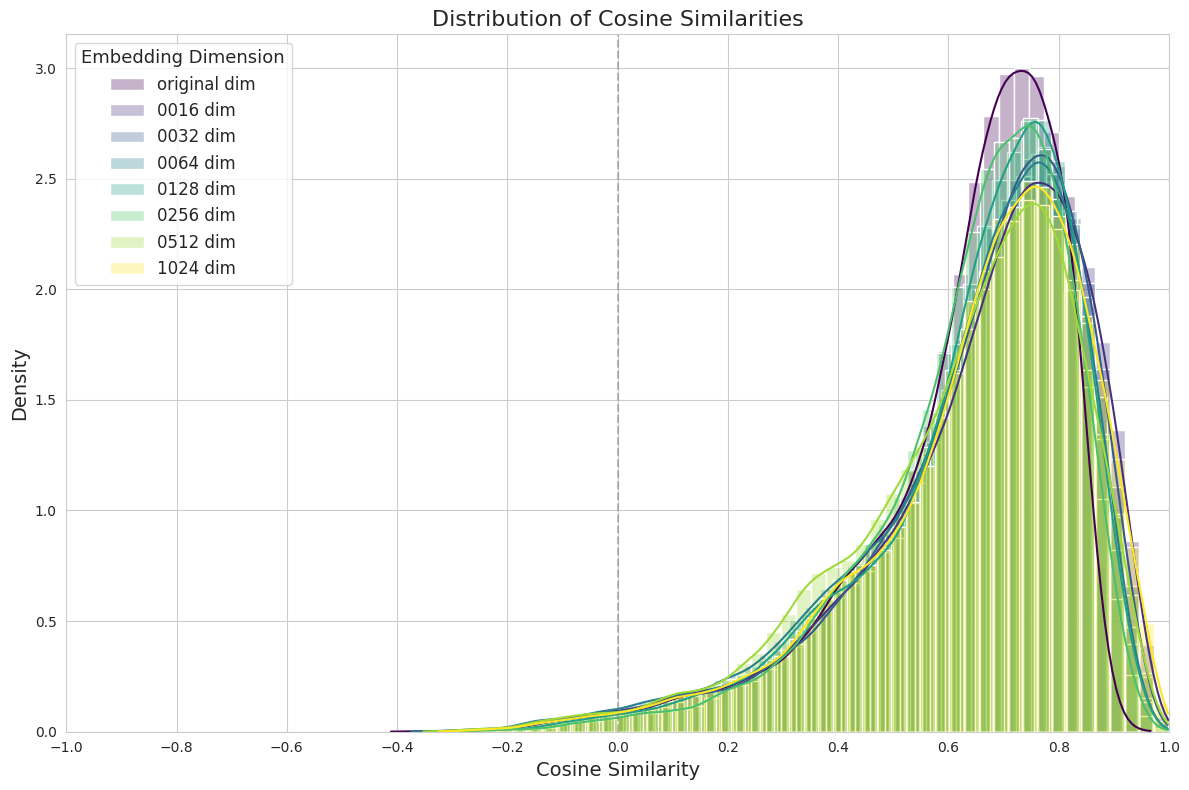

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
plt.title('Distribution of Cosine Similarities', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Define the columns to plot (all similarity columns)
similarity_cols = [col for col in df_cosine_similarities.columns
                  if col.startswith('similarity')]

# Create color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(similarity_cols)))

# Plot each histogram with density curve
for i, col in enumerate(similarity_cols):
    # Extract the dimension from column name for legend
    dim = col.split('_')[-1] if col != 'similarity_original' else 'original'

    sns.histplot(
        df_cosine_similarities[col],
        bins=50,
        alpha=0.3,  # Transparency for overlapping areas
        kde=True,   # Add kernel density estimate
        stat='density',
        color=colors[i],
        label=f'{dim} dim'
    )

# Add vertical line at mean and customize x-axis
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlim(-1, 1)
plt.xticks(np.arange(-1, 1.1, 0.2))

# Add legend and adjust layout
plt.legend(title='Embedding Dimension', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
df_cosine_similarities.to_csv(f"{path_prefix}/df_cosine_similarities_similarity_space.csv", index=False)

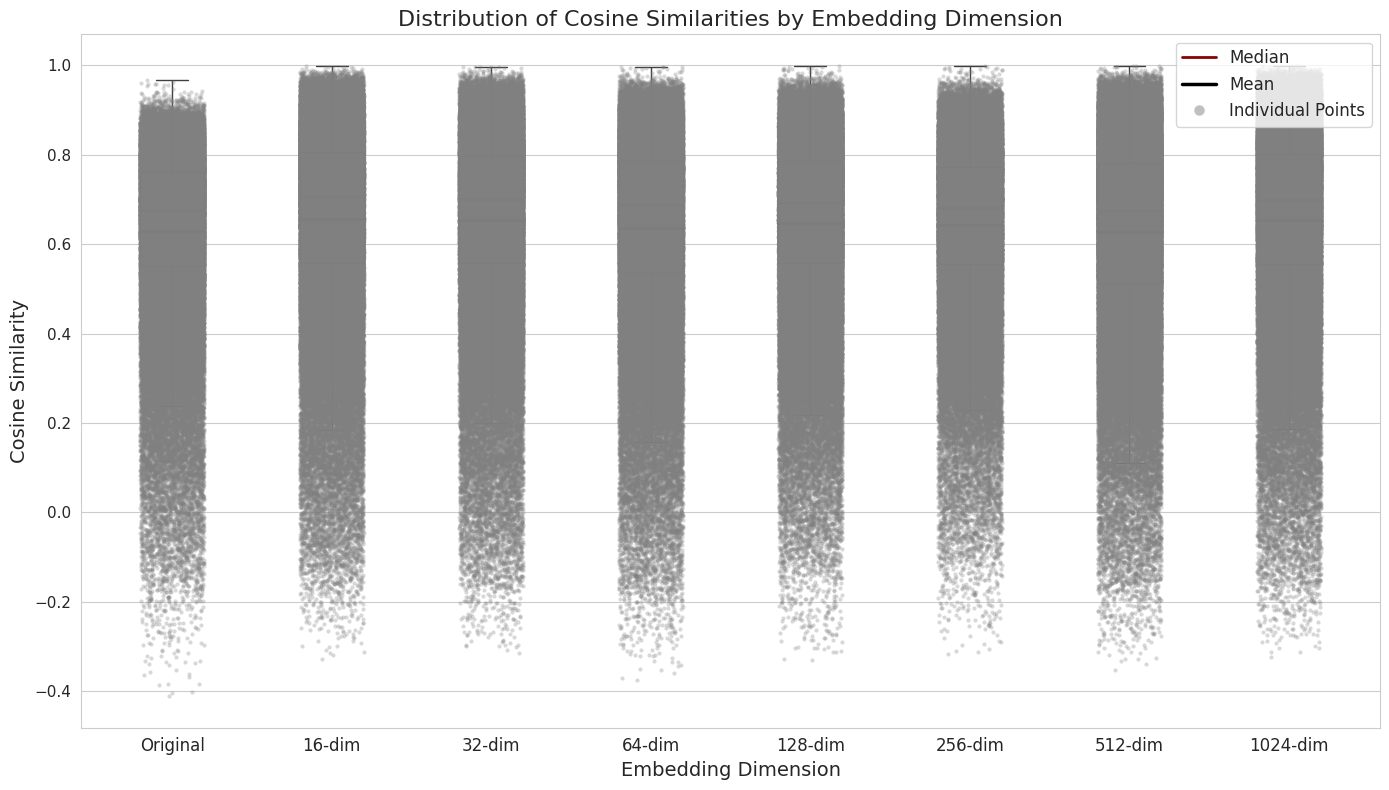

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data in long format
similarity_cols = [col for col in df_cosine_similarities.columns
                  if col.startswith('similarity')]
df_long = pd.melt(
    df_cosine_similarities[similarity_cols],
    var_name='Embedding Type',
    value_name='Cosine Similarity'
)

# Create ordered categories based on dimension size
dim_order = {
    'similarity_original': 'Original',
    'similarity_ae_0016': '16-dim',
    'similarity_ae_0032': '32-dim',
    'similarity_ae_0064': '64-dim',
    'similarity_ae_0128': '128-dim',
    'similarity_ae_0256': '256-dim',
    'similarity_ae_0512': '512-dim',
    'similarity_ae_1024': '1024-dim'
}
df_long['Embedding Type'] = df_long['Embedding Type'].map(dim_order)
ordered_categories = list(dim_order.values())

# Create the plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Create strip plot for all data points
ax = sns.stripplot(
    x='Embedding Type',
    y='Cosine Similarity',
    data=df_long,
    order=ordered_categories,
    alpha=0.3,
    color='gray',
    size=3,
    jitter=0.2
)

# Overlay boxplot for distribution summary
sns.boxplot(
    x='Embedding Type',
    y='Cosine Similarity',
    data=df_long,
    order=ordered_categories,
    showfliers=False,
    width=0.4,
    boxprops={'facecolor': (0.4, 0.6, 0.8, 0.5)},
    medianprops={'color': 'darkred', 'linewidth': 2}
)

# Add mean indicators
means = df_long.groupby('Embedding Type')['Cosine Similarity'].mean().loc[ordered_categories]
for i, mean_val in enumerate(means):
    plt.plot([i-0.2, i+0.2], [mean_val, mean_val], color='black', linewidth=2.5)

# Add labels and title
plt.title('Distribution of Cosine Similarities by Embedding Dimension', fontsize=16)
plt.xlabel('Embedding Dimension', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='darkred', lw=2, label='Median'),
    Line2D([0], [0], color='black', lw=2.5, label='Mean'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, alpha=0.5, label='Individual Points')
]
plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3066097870.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


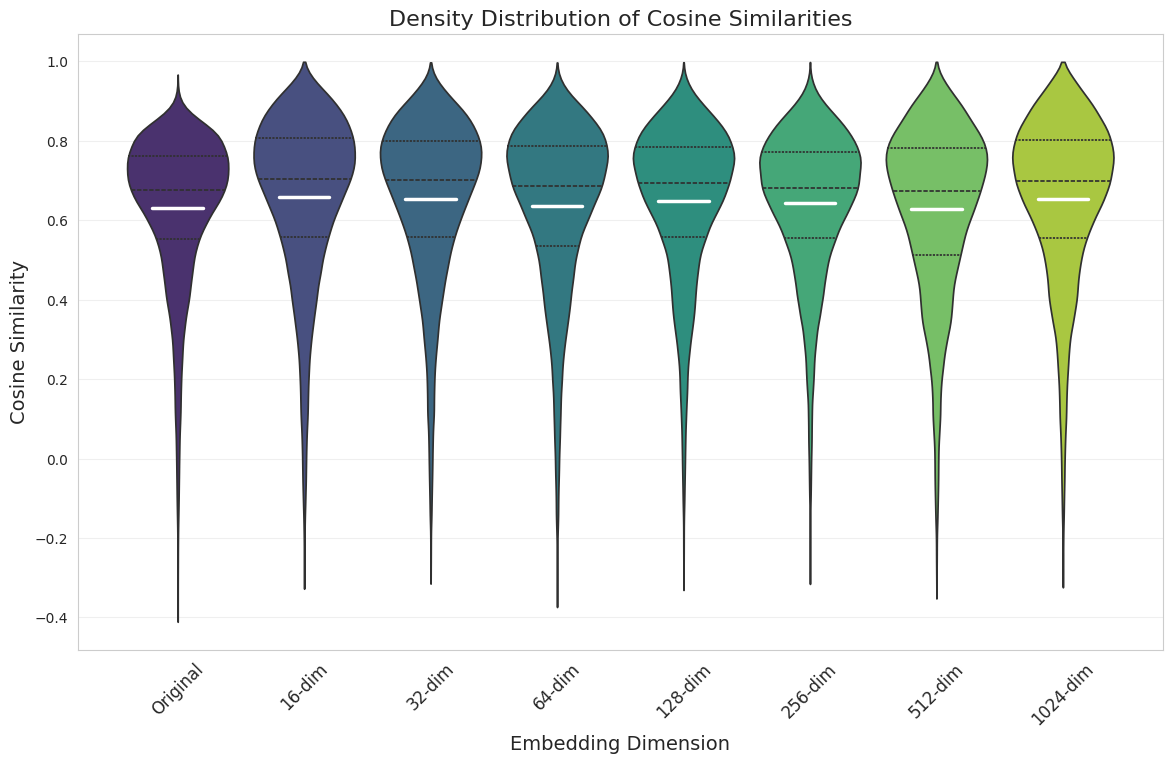

In [ ]:
plt.figure(figsize=(14, 8))
sns.violinplot(
    x='Embedding Type',
    y='Cosine Similarity',
    data=df_long,
    order=ordered_categories,
    inner="quartile",
    cut=0,
    palette="viridis"
)

# Add mean indicators
for i, mean_val in enumerate(means):
    plt.plot([i-0.2, i+0.2], [mean_val, mean_val], color='white', linewidth=2.5)

plt.title('Density Distribution of Cosine Similarities', fontsize=16)
plt.xlabel('Embedding Dimension', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.show()

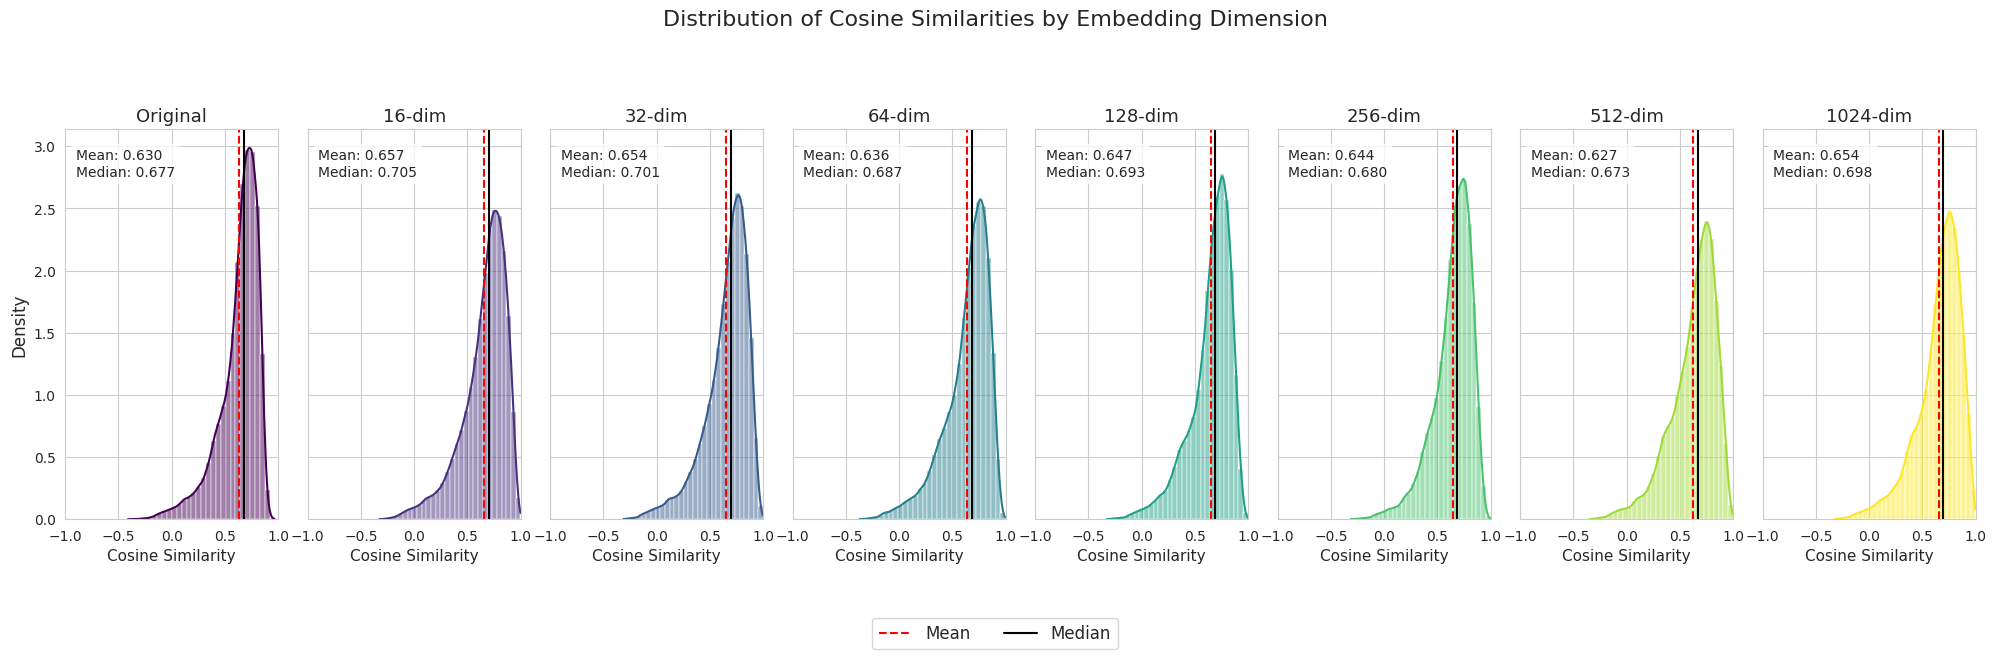

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data
similarity_cols = sorted([col for col in df_cosine_similarities.columns
                         if col.startswith('similarity')],
                         key=lambda x: int(x.split('_')[-1]) if '_ae_' in x else 0)

# Create dimension labels
dim_labels = {
    'similarity_original': 'Original',
    'similarity_ae_0016': '16-dim',
    'similarity_ae_0032': '32-dim',
    'similarity_ae_0064': '64-dim',
    'similarity_ae_0128': '128-dim',
    'similarity_ae_0256': '256-dim',
    'similarity_ae_0512': '512-dim',
    'similarity_ae_1024': '1024-dim'
}

# Set up plot grid
n_cols = len(similarity_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(20, 6), sharey=True)
fig.suptitle('Distribution of Cosine Similarities by Embedding Dimension',
             fontsize=16, y=1.05)

# Create color gradient
colors = plt.cm.viridis(np.linspace(0, 1, n_cols))

# Plot each histogram
for i, col in enumerate(similarity_cols):
    ax = axes[i]
    sns.histplot(
        df_cosine_similarities[col],
        bins=30,
        color=colors[i],
        kde=True,
        ax=ax,
        stat='density'
    )

    # Add mean line
    mean_val = df_cosine_similarities[col].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5)

    # Add median line
    median_val = df_cosine_similarities[col].median()
    ax.axvline(median_val, color='black', linestyle='-', linewidth=1.5)

    # Customize subplot
    ax.set_title(dim_labels.get(col, col), fontsize=13)
    ax.set_xlabel('Cosine Similarity', fontsize=11)
    ax.set_xlim(-1, 1)

    # Only add y-label to first plot
    if i == 0:
        ax.set_ylabel('Density', fontsize=12)

    # Add statistics annotation
    stats_text = f'Mean: {mean_val:.3f}\nMedian: {median_val:.3f}'
    ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
                ha='left', va='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color='red', linestyle='--', lw=1.5, label='Mean'),
    plt.Line2D([0], [0], color='black', linestyle='-', lw=1.5, label='Median')
]
fig.legend(handles=legend_elements, loc='upper center',
           bbox_to_anchor=(0.5, 0.05), ncol=2, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.2)
plt.show()